![title](img/skimlit.png)


<a style="margin: 0 5px" href="https://colab.research.google.com/drive/1iceHKxffz_oLud9Zoxu300FZKANyI6kx?usp=sharing"><img    src="https://colab.research.google.com/assets/colab-badge.svg"></a>

## 📖 The purpose of SkimLit is to build a NLP model to make reading medical abstracts easier.

The paper being replicated is available [here](https://arxiv.org/abs/1710.06071) <br>
The dataset can be found [here](https://github.com/Franck-Dernoncourt/pubmed-rct.git)

---
### ⬇️ Download the <span style="color:green">data</span>.
Start with the smaller, 20k Dataset. Once a model that performs best with the 20k dataset is found, upscale the model to train on the 200k dataset 

In [2]:
import os

# If file doesn't already exist, download the dataset
if os.path.exists('./data/pubmed-rct'):
    print("File already exists")
    
else:
    !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

File already exists


In [3]:
# List files inside the PubMed_20k dataset
!ls data/pubmed-rct/pubmed_20k_rct_numbers_replaced_with_at_sign/
!ls data/pubmed-rct/pubmed_20k_rct/

dev.txt   test.txt  train.txt
dev.txt   test.txt  train.txt


In [4]:
# Start with the smaller dataset, with numbers replaced with "@" sign
data_dir = "data/pubmed-rct/pubmed_20k_rct_numbers_replaced_with_at_sign/"

---
<h1 align="center">🤖 Preprocess Data</h3> 

In [5]:
# Create a function that reads the lines of a document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.

    Args:
      filename: a string containing the target filepath to read.

    Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
    """
    with open(filename, "r") as f:
        return f.readlines()

In [6]:
# Read the lines of the training dataset, into a variable
train_lines = get_lines(data_dir + "train.txt") 

# Show the first 10 lines
train_lines[:10] 

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
print(f'There are {len(train_lines)} training lines')

There are 210040 training lines


### Dataset Format
Load data into python dictionaries, this adds structure to the dataset that the text file doesn't have

```
[
    {
        'line_number': 0,
        'target': 'BACKGROUND',
        'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
        'total_lines': 11
    },

    # Next instance of data
    {
        ......
    }
]
```
### Define a function to load data into the data structure shown above

In [8]:
def preprocess_text(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract and what sentence number
    the target line is.

    Args:
      filename: a string of the target text file to read and extract line data
      from.

    Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

    input_lines = get_lines(filename)
    abstract_lines = "" # Create
    abstract_samples = []

    for line in input_lines:
        
        if line.startswith("###"): # Check to see if the new line is the ID label
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line is the ID

        # A space indicates the start of another abstract, so we have to process the current abstract before moving
        # a new abstract
        elif line.isspace(): # Check if the new line is a space
            
            # Split the abstract into seperate lines
            # the splitlines() function looks for a line break and splits the lines
            abstract_line_split = abstract_lines.splitlines() # Returns a list of strings
        
            # Iterate through each line in the abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                # Populate the dictionary with the line data
                abstract_dict = {}

                # Splits the target text and text
                target_text_split = abstract_line.split('\t')

                # Populate the dictionary
                abstract_dict['target'] = target_text_split[0]
                abstract_dict['text'] = target_text_split[1].lower()
                abstract_dict['line_number'] = abstract_line_number
                abstract_dict['total_lines'] = len(abstract_line_split) - 1 # We want to start from 0

                abstract_samples.append(abstract_dict)

        # If neither of the above two criteria is fulfilled, the line is a target label / text line
        # So just append the data into the abstract_lines string
        else:
            abstract_lines += line
        
    return abstract_samples

### 🖖🏽 Dataset Split

In [9]:
%%time

# Get the data and preprocess it
train_samples = preprocess_text(data_dir + 'train.txt')
val_samples = preprocess_text(data_dir + 'dev.txt') # dev is another name for validation
test_samples = preprocess_text(data_dir + 'test.txt')
print("No. of training samples: {} \nNo. of validation samples: {} \nNo. of testing samples: {}"
        .format(len(train_samples), len(val_samples), len(test_samples))
)

No. of training samples: 180040 
No. of validation samples: 30212 
No. of testing samples: 30135
CPU times: user 458 ms, sys: 58.9 ms, total: 517 ms
Wall time: 523 ms


In [10]:
train_samples[:12] # Check the lines of the first abstract in the training abstract

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd

# Turn dictionaries into pandas DataFrame to better visualize it
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# Show first 13 lines of data
train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


---
<h1 align="center">👨🏽‍💻 Dataset Analysis</h3> 


<AxesSubplot:>

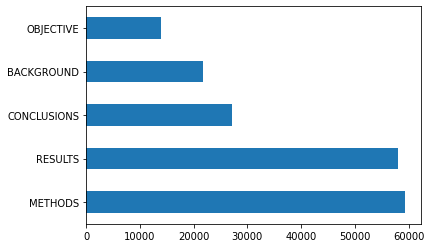

In [12]:
# Visualize the distribution in training data (according to no. of samples per target)

train_df['target'].value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Frequency'>

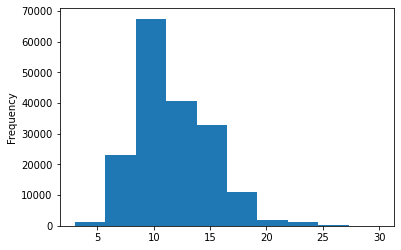

In [13]:
# Let's check the distribution of the length of lines
train_df['total_lines'].plot.hist()

<b>Get list of sentences</b> <br>
The main inputs to the deep learning model, would be a list of strings which we can obtain via the function below

In [14]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences),

(180040, 30212, 30135)

In [15]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

---
<h1 align="center">🛠 Feature Engineering</h3> 


### Encoding
ML models require numeric labels <br>
<br>
<b>Two methods</b>
1. Label Encode (e.g `Methods -- 1, Results -- 2, ...`)
2. One-hot encode (e.g `Methods -- [1,0,0,0,0], Results -- [0,1,0,0,0]`)

> <b>What does `sparse` mean?</b> <br>
A sparse array is one that contains mostly zeros and few non-zero entries

> <b>What does `dense` mean?</b> <br>
A dense array contains mostly non-zeros

### 1️⃣ One-hot encode labels

In [16]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))


In [17]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

2021-08-28 15:28:19.713744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### 2️⃣ Label encode labels

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded # These labels are label encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class (reverse engineer to get the class names)
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments
Trying out different models and seeing which one works best

| Experiment | Model Name |
| --- | --- |
| 0 | TF-IDF Multinomial Naive Bayes Classifier (Baseline) |
| 1 | Conv1D with token embeddings |
| 2 | TensorFlow Hub Pretrained Feature Extractor |
| 3 | Conv1D with character embeddings |
| 4 | Pretrained token embeddings (same as 2) + character embeddings (same as 3) |
| 5 | Pretrained token embeddings + character embeddings + positional embeddings |

---

![title](img/model_0.png)

<b>Naive Bayes Classifier</b>


Bayes Theorem 

$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$

If any two events are independent, then $P(A,B) = P(A)P(B)$

Using the above two concepts, we can reach this result

P(y|X) = $\frac{P(X|y)P(y)}{P(X)}$ where X = (x_1, x_2, ..., x_n)


P(y|x_1,...x_n) = $\frac{P(x_1|y)...P(x_n|y)P(y)}{P(x_1)...P(x_n)}$

y = $argmax_yP(y)\sum_{i=1}^{n}P(x_i|y)$

<b>Term Frequency - Inverse Document Frequency</b>

Generally used to compute how important/relevant a word is to a certain document. It approaches 0 when it is a common word (e.g 'when', 'the', etc) and 1 when it is unique.

# 🏋️‍♀️ Model Training

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

# ✍🏽 Model Evaluation
### ❌ Cross validation

In [22]:
from sklearn.model_selection import cross_val_predict

# Make predictions using the Naive Bayes Classifier
baseline_preds = model_0.predict(val_sentences)

# Make predictions using the K-fold cross validation
y_val_preds = cross_val_predict(model_0, val_sentences, val_labels_encoded, cv=3)

print(baseline_preds)
print(y_val_preds)

[4 1 3 ... 4 4 1]
[4 1 2 ... 4 4 0]


### 🤔 Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
'''
An optimal confusion matrix would be one with non-zero integers in the diagonal (top left to bottom right)

1 0 0 0 0
0 1 0 0 0
0 0 1 0 0
0 0 0 1 0
0 0 0 0 1
'''

confusion_matrix(val_labels_encoded, baseline_preds)

array([[1683,  794,  694,   97,  181],
       [ 244, 2687,  432,    5, 1214],
       [ 116,   75, 8670,    7, 1096],
       [ 505,  422,  978,  325,  146],
       [  20,  181, 1196,    1, 8443]])

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculate_results(y_true, y_pred):
    '''
    Calculates model accuracy, precision, recall, f1 score of a binary classification model
    
    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array
        
    Returns:
        A dictionary of metrics
    '''
    
    # Calculate the model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Calculate the model precision, recall and f1 score
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    model_f1 = f1_score(y_true, y_pred, average='weighted')
    
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

### ⚖️ Metrics

In [25]:
# Calculate the baseline results on the validation dataset
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=y_val_preds)

In [26]:
all_model_results = pd.DataFrame({
    "Multinomial Naive Bayes Classifier": baseline_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,f1,precision,recall
Multinomial Naive Bayes Classifier,66.483516,0.618607,0.668206,0.664835


Above are the model results for the <b>baseline model</b>. We aim to beat these results in the upcoming experiments

---
![title](img/model_1.png)

# 👨🏽‍💻 Dataset Analysis


### Prepare data for deep sequence modelling
In order to train our deep neural networks, we need to preprocess our data in a different way. Namely, tokenization and embedding layers. <br> 
The following code is to obtain more information about the `training_sentences` so we can create the tokenization layers with appropriate parameters

<b>✍🏽Average Sentence length<b>

In [27]:
# Import relevant libraries for creating vectorization and embedding layers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# If we want to create embedding layers, we need the sentences to be of equal lengths
sentence_lengths = [len(sentence.split()) for sentence in train_sentences] # Must use .split() since we only want words
avg_sentence_length = np.mean(sentence_lengths)

avg_sentence_length

26.338269273494777

<b>📊Visualize the distribution of sentence lengths<b>

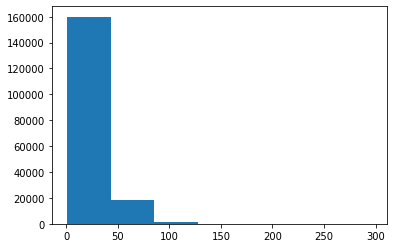

In [29]:
# Visualize the distribution of sentence lengths to get a clearer picture
import matplotlib.pyplot as plt
plt.hist(sentence_lengths, bins=7);

Looks like majority of the sentences are between 0 and 50 tokens in length

In [30]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentence_lengths, 95))
output_seq_len

55

This means that 95% of the sentences have 55 tokens or less. When creating the tokenization layer, we'll use this value to make all sentences the same length. Sentences with lengths below 55 get padded with zeros and those above get truncated.

In [31]:
# Calculate the maximum length of the sentences
max(sentence_lengths)

296

Since 95% of sentences are below 55 tokens in length, it wouldn't make sense to set 296 as the maximum length because then, majority of the data we pass to our model would be zeros (from padding)

## Convert sentences into numbers
Method 1: <b> Text Vectorizer </b>
<br>
Method 2: <b> Tokenizer</b>

### 1️⃣ Creating a Text vectorizer
Using the information from above, the appropriate value for `max_length` is 55.

In [32]:
# Vocabulary size for the 20k dataset is 68000 according to the paper
max_tokens = 68000
max_length = 55

In [33]:
# Two methods, TextVectorization & Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens=max_tokens, # Number of words in vocabulary 
    output_sequence_length = max_length # Desired output of vectorized sentences
)

In [34]:
# Adapt textvectorizer to training sentences
text_vectorizer.adapt(train_sentences)

2021-08-28 15:28:28.826303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [35]:
# Testing out the text vectorizer
import random

random_sentence = random.choice(train_sentences)
print(f"Actual Text:\n{random_sentence}\n")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized sentence:\n{text_vectorizer([random_sentence])}")

Actual Text:
brief fr is a simple , inexpensive technique that may reduce na in college health settings and help decrease delays in treatment seeking .

Length of text: 24

Vectorized sentence:
[[ 960 4115   20    8  981 5432  475   28   91  270 3078    5 2114   97
  1094    3  909  318 4791    5   19 3128    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Re-run the cell to get different sentences. Notice that shorter sentences get padded with more zeros.

### Obtain vocab list
Obtain vocabulary of the dataset, using the `.get_vocabulary()` method of the text vectorizer

In [36]:
rct_20k_vocab = text_vectorizer.get_vocabulary()

# Get the size of the vocabulary
print(f"Number of words in vocabulary: {len(rct_20k_vocab)}\n")
print(f"Most commmon words in vocabulary: {rct_20k_vocab[:5]}\n")
print(f"Least common words in vocabulary: {rct_20k_vocab[-5:]}")

Number of words in vocabulary: 64841

Most commmon words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']

Least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


Get the configuration of the text vectorizer using the `.get_config()` method

In [37]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

### Create text embeddings
Earlier, we mapped words to numbers, but this doesn't capture relationships between the numbers. To do this, we can use <b>embeddings</b>

In [38]:
embedding_dim = 128

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Show an instance of embedding
print(f"Sentence before embedding:\n{random_sentence}\n")

vectorized_sentence = text_vectorizer([random_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Shape of embedded sentence: {embedded_sentence.shape}\n")

Sentence before embedding:
brief fr is a simple , inexpensive technique that may reduce na in college health settings and help decrease delays in treatment seeking .

Sentence after vectorization (before embedding):
[[ 960 4115   20    8  981 5432  475   28   91  270 3078    5 2114   97
  1094    3  909  318 4791    5   19 3128    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.01750016 -0.01254452 -0.04888484 ...  0.02556861 -0.00914514
   -0.04283677]
  [ 0.02729143  0.0266268  -0.03680147 ... -0.01211009 -0.00781734
    0.02262756]
  [ 0.03698936 -0.0203568   0.03268761 ...  0.04339674  0.04158126
   -0.01645691]
  ...
  [-0.01257067 -0.02364277  0.02363184 ...  0.01493958  0.02573258
   -0.00991319]
  [-0.01257067 -0.02364277  0.02363184 ...  0.01493958  0.02573258
   -0.00991319]
  [-0.01257067 -0.02364277  0.02363184 ...  0.01493

### Create datasets (for quick runtime)
The tf.data API provides methods that enable faster data loading <br>
Create a PrefetchDataset of batches from our data that we have prepared. Use the batch() and prefetch() method, and the tf.data.AUTOTUNE (allow tf to determine the optimal amount of compute to prepare datasets)

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [40]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# 🏋️‍♀️ Model Training

The input data to a deep sequence model is different from the one we feeded into a naive bayes model. We need to prepare data in another format
> Input (text) ➡ Tokenizer ➡ Embedding ➡ Layers ➡ Output (label probability)

After building our model
> Build model ➡ Train model ➡ Evaluate model (compare with ground truth and baseline model performance)

In [41]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [42]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [43]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 38s 67ms/step - loss: 0.9223 - accuracy: 0.6299 - val_loss: 0.7014 - val_accuracy: 0.7317
Epoch 2/3
562/562 [==============================] - 38s 67ms/step - loss: 0.6688 - accuracy: 0.7512 - val_loss: 0.6407 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 38s 68ms/step - loss: 0.6247 - accuracy: 0.7713 - val_loss: 0.5994 - val_accuracy: 0.7862


# ✍🏽 Model Evaluation
### ❌ Cross validation

In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 1s 1ms/step - loss: 0.6028 - accuracy: 0.7853


[0.6028474569320679, 0.785317063331604]

In [45]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.1601500e-01, 1.8071696e-01, 7.6475225e-02, 2.9905215e-01,
        2.7740702e-02],
       [4.1035190e-01, 3.2293937e-01, 8.0038356e-03, 2.5223228e-01,
        6.4725862e-03],
       [1.5408161e-01, 1.2729758e-02, 1.8278150e-03, 8.3132201e-01,
        3.8706505e-05],
       ...,
       [2.6711325e-06, 5.7343312e-04, 8.0793485e-04, 1.8414834e-06,
        9.9861407e-01],
       [5.6430999e-02, 5.3369349e-01, 7.5182706e-02, 6.4857133e-02,
        2.6983565e-01],
       [2.2802907e-01, 5.5391818e-01, 5.8656145e-02, 8.1564553e-02,
        7.7832095e-02]], dtype=float32)

In [46]:
# Convert these probabilities into classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

### ⚖️ Metrics

In [47]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.53170925460083,
 'precision': 0.7819417654925646,
 'recall': 0.7853170925460082,
 'f1': 0.7828465371798523}

In [48]:
all_model_results = pd.DataFrame({
    "Multinomial Naive Bayes Classifier": baseline_results,
    "Conv1D w/ token embeddings": model_1_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Multinomial Naive Bayes Classifier,66.483516,0.668206,0.664835,0.618607
Conv1D w/ token embeddings,78.531709,0.781942,0.785317,0.782847


In [49]:
model_1.save('model_1/saved_model')

2021-08-28 15:30:30.046882: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_1/saved_model/assets


---
![title](img/model_2.png) 


Use the pretrained embeddings as a way to initialize token embeddings

The tokenizer layer is _missing_, but the Universal Sentence Encoder will take care of the tokenisation for us.

# 🏋️‍♀️ Model Training

### Use a pretrained embedding layer from TFHub
To download the pretrained USE, and use it in our model, we can use `Hub.KerasLayer`.
Keep the pre-trained embedding layer(by setting the method `trainable=False` and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [56]:
import tensorflow_hub as hub

# the model is relatively large, so it may take a while to load
universal_sentence_encoder = hub.KerasLayer("./data/universal-sentence-encoder_4",
                                       trainable=False,
                                       name="universal_sentence_encoder")

In [57]:
# Test the layer
random_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_sentence}\n")

embedded_sentence = universal_sentence_encoder([random_sentence])
print(f"Sentence after embeddding:\n{embedded_sentence}\n")

print(f"Length of sentence after embeddding:\n{len(embedded_sentence[0])}\n")

Random training sentence:
maternal depressive symptoms moderated the effect of cbt , but not sbft , on adolescents ' problem solving ; adolescents experienced increases in problem solving only when their mothers had low or moderate levels of depressive symptoms .

Sentence after embeddding:
[[ 3.93456742e-02 -1.14758476e-03  3.34811024e-02 -4.88323942e-02
  -7.34819919e-02  6.60400689e-02 -3.67805897e-03 -4.38062325e-02
   1.40553871e-02  5.85198291e-02  7.36998990e-02  1.10934430e-03
   4.86762822e-02  1.00040762e-02  1.56840552e-02 -7.54158720e-02
  -7.55787566e-02  6.53630123e-02  1.60627868e-02 -7.35875815e-02
   5.53362668e-02  7.14916959e-02 -3.09081376e-02 -4.94390912e-02
   5.18502519e-02 -3.14867236e-02 -2.69715711e-02 -3.93605381e-02
   1.44846337e-02  1.07851718e-02 -3.94855849e-02  7.49554783e-02
  -1.49984844e-02  3.82143855e-02 -3.55118476e-02  6.33953139e-02
   1.15757845e-02 -5.69755323e-02 -2.63111386e-02 -5.60043454e-02
   5.93202673e-02  7.47235343e-02 -4.57361154e-0

In [58]:
# Build a model around the tf_hub_embedding_layer
inputs = layers.Input(shape=[], dtype=tf.string)

# Tokenize and embedding layer
pretrained_embedding_layer = universal_sentence_encoder(inputs)

# Dense layer
x = layers.Dense(128, activation='relu')(pretrained_embedding_layer)

# Output layer
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Print the model summary
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


Looking at the summary, most of the parameters are non-trainable, this is because we set `trainable=False` when initializing the Universal Sentence Encoder (USE)

In [59]:
if os.path.exists('model_2/saved_model'):
    tf.keras.backend.clear_session()
    model_2 = tf.keras.models.load_model('model_2/saved_model')
    
else:
    model_2_history = model_2.fit(train_dataset,
                                 steps_per_epoch=int(0.1 * len(train_dataset)),
                                 epochs=3,
                                 validation_data=valid_dataset,
                                 validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 7ms/step - loss: 0.9157 - accuracy: 0.6487 - val_loss: 0.7960 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7673 - accuracy: 0.7022 - val_loss: 0.7523 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7502 - accuracy: 0.7135 - val_loss: 0.7365 - val_accuracy: 0.7131


# ✍🏽 Model Evaluation

In [60]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.7386 - accuracy: 0.7145


[0.738615095615387, 0.7144511938095093]

In [61]:
# MAKE PREDICTIONS WITH THE NEWLY TRAINED MODEL

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3255129e-01, 3.5521135e-01, 2.0533316e-03, 2.0135774e-01,
        8.8263052e-03],
       [3.4356654e-01, 4.8924577e-01, 3.0465256e-03, 1.6146268e-01,
        2.6784164e-03],
       [2.4661611e-01, 1.4951919e-01, 1.9181486e-02, 5.4299027e-01,
        4.1692950e-02],
       ...,
       [2.1114282e-03, 5.5661756e-03, 5.6280199e-02, 8.0316979e-04,
        9.3523908e-01],
       [3.8391377e-03, 5.0732717e-02, 2.0159803e-01, 1.2064138e-03,
        7.4262375e-01],
       [1.7332198e-01, 2.7035755e-01, 5.0216436e-01, 5.5560223e-03,
        4.8600171e-02]], dtype=float32)

In [62]:
# Convert the predictions into labels

# Use axis=1 to get argmax of lists in the second axis. If axis=0 is used, indexes of the list containing the largest value for each axis will be returned
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) # axis=0 by default
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [63]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)

### Compare the model results so far

In [64]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.531709,0.781942,0.785317,0.782847
pretrained token embedding layer,71.445121,0.714712,0.714451,0.711513


In [65]:
model_2.save('model_2/saved_model')

INFO:tensorflow:Assets written to: model_2/saved_model/assets


---
![title](img/model_3.png) 


# 👨🏽‍💻 Dataset Analysis

In [66]:
# Define a helper function to split the sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Test out the function
split_chars(random_sentence)

"m a t e r n a l   d e p r e s s i v e   s y m p t o m s   m o d e r a t e d   t h e   e f f e c t   o f   c b t   ,   b u t   n o t   s b f t   ,   o n   a d o l e s c e n t s   '   p r o b l e m   s o l v i n g   ;   a d o l e s c e n t s   e x p e r i e n c e d   i n c r e a s e s   i n   p r o b l e m   s o l v i n g   o n l y   w h e n   t h e i r   m o t h e r s   h a d   l o w   o r   m o d e r a t e   l e v e l s   o f   d e p r e s s i v e   s y m p t o m s   ."

In [67]:
# Split sentence into character-level split data 
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [68]:
# What's the average character length
char_lengths = [len(sentence) for sentence in train_sentences] # Unlike the token-level split data, don't use the .split() method as we want number of characters
mean_char_length = np.mean(char_lengths)

mean_char_length

149.3662574983337

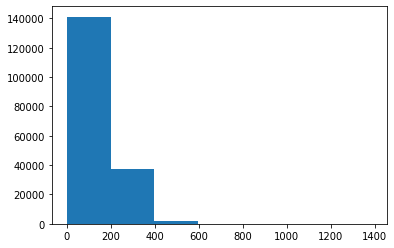

In [69]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

Looks like majority of the sequences are between 0 and 200 characters long.

Find out the 95th percentile of sequence lengths

In [70]:
output_seq_char_length = int(np.percentile(char_lengths,95))
output_seq_char_length

290

Now that we have the optimal output sequence length, we need to find the value of max_tokens, and other parameters

In [71]:
# Get all the keyboard characters for character level embedding
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create a character level token vectorizer instance
max_tokens = len(alphabet)

char_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_char_length,
                                   standardize='lower_and_strip_punctuation',
                                   name='char_vectorizer')

# Adapt the training data to the char-level vectorizer
char_vectorizer.adapt(train_chars)

After adapting the vectorizer to the char-level vectorizer, let's check some charateristics about it and obtain the vocabulary

In [73]:
char_vocab = char_vectorizer.get_vocabulary()

print(f"Number of unique characters in the vocabulary:\n{len(char_vocab)}\n")
print(f"Least commmon characters:\n{char_vocab[-5:]}\n")
print(f"Most common characters:\n{char_vocab[:5]}\n")

Number of unique characters in the vocabulary:
28

Least commmon characters:
['k', 'x', 'z', 'q', 'j']

Most common characters:
['', '[UNK]', 'e', 't', 'i']



Let's test it on random sentences

In [74]:
random_train_chars = random.choice(train_chars)

print(f"Text that is split at character-level:\n{random_train_chars}\n")
print(f"Length of character sequence:\n{len(random_train_chars.split())}\n")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized character sequence:\n{vectorized_chars}\n")
print(f"Length of vectorized character sequences(after padding):\n{len(vectorized_chars[0])}") # Access the zeroth index because of the double nested list

Text that is split at character-level:
h o w e v e r   ,   s y s t e m a t i c   f a c t o r s   i n c l u d i n g   t h e   s h o r t a g e   o f   t r a i n e d   p r o f e s s i o n a l s   a n d   t h e   r e l a t i v e   u n d e r d e v e l o p m e n t   o f   s e r v i c e s   a l s o   m a k e   a c c e s s   d i f f i c u l t . s t e p p e d - c a r e   c a n   i n c r e a s e   a c c e s s   t o   e v i d e n c e - b a s e d   c b t   .

Length of character sequence:
180

Vectorized character sequence:
[[13  7 20  2 21  2  8  9 19  9  3  2 15  5  3  4 11 17  5 11  3  7  8  9
   4  6 11 12 16 10  4  6 18  3 13  2  9 13  7  8  3  5 18  2  7 17  3  8
   5  4  6  2 10 14  8  7 17  2  9  9  4  7  6  5 12  9  5  6 10  3 13  2
   8  2 12  5  3  4 21  2 16  6 10  2  8 10  2 21  2 12  7 14 15  2  6  3
   7 17  9  2  8 21  4 11  2  9  5 12  9  7 15  5 23  2  5 11 11  2  9  9
  10  4 17 17  4 11 16 12  3  9  3  2 14 14  2 10 11  5  8  2 11  5  6  4
   6 11  8  2  5  9  2  5 11 11  2  9 

Sequences that are shorter than 290 characters in length are <b>padded</b> while those that are longer get truncated, ensuring that all sequences passed into the model are equal in length. 

The `standardize` parameter being set to `lower_and_strip_punctuation` and the split function ensures that punctuation, symbols and whitespaces are removed during the vectorization process

### Create character-level embeddings

In [75]:
char_embed = layers.Embedding(input_dim=max_tokens,
                             output_dim=25,
                             mask_zero=True,
                             name='char_embed')

# Test out the character embedding layer
print(f"Character-level text(before embedding and vectorization):\n{random_train_chars}\n")

random_char_embed = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded Characters (after vectorization and embedding):\n{random_char_embed}\n")
print(f"Character-embedded shape: {random_char_embed.shape}\n")

Character-level text(before embedding and vectorization):
h o w e v e r   ,   s y s t e m a t i c   f a c t o r s   i n c l u d i n g   t h e   s h o r t a g e   o f   t r a i n e d   p r o f e s s i o n a l s   a n d   t h e   r e l a t i v e   u n d e r d e v e l o p m e n t   o f   s e r v i c e s   a l s o   m a k e   a c c e s s   d i f f i c u l t . s t e p p e d - c a r e   c a n   i n c r e a s e   a c c e s s   t o   e v i d e n c e - b a s e d   c b t   .

Embedded Characters (after vectorization and embedding):
[[[ 0.02781377  0.04172577 -0.02508597 ... -0.03270992 -0.00969479
   -0.04536424]
  [-0.02203144 -0.02512615 -0.02599045 ... -0.01138477  0.03838642
   -0.0101267 ]
  [-0.04836696  0.04893669  0.03181137 ...  0.04050303 -0.03547303
    0.04371593]
  ...
  [ 0.01268393  0.04179719 -0.03621278 ...  0.02073069 -0.01119449
    0.03940651]
  [ 0.01268393  0.04179719 -0.03621278 ...  0.02073069 -0.01119449
    0.03940651]
  [ 0.01268393  0.04179719 -0.03621278 ...  0.02073

Basically, for one sentence, there are 290 characters, and each character has 25 dimensions, as stated in the `output_dim` method.

# 🏋️‍♀️ Model Training

In [76]:
# Make Conv1D for characters only

inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_3_conv1d_char_embedding')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Check the summary of the char_embedding model
model_3.summary()

Model: "model_3_conv1d_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1700      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,089
Trainable params: 10,089
Non-trainable params: 0
_________________________________

### Create Char Dataset

In [77]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [78]:
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch = int(0.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data = val_char_dataset,
                             validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.2595 - accuracy: 0.4820 - val_loss: 1.0416 - val_accuracy: 0.5901
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 1.0088 - accuracy: 0.5944 - val_loss: 0.9415 - val_accuracy: 0.6376
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9265 - accuracy: 0.6350 - val_loss: 0.8649 - val_accuracy: 0.6672


# ✍🏽 Model Evaluation

In [79]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 1s 2ms/step - loss: 0.8894 - accuracy: 0.6550


[0.8894333839416504, 0.6550377607345581]

In [80]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.12289768, 0.32492566, 0.06808171, 0.44896588, 0.03512901],
       [0.19527265, 0.49015617, 0.01642498, 0.2866022 , 0.01154403],
       [0.12380609, 0.13964297, 0.18151167, 0.5292199 , 0.02581931],
       ...,
       [0.0182239 , 0.03506847, 0.2732532 , 0.03597685, 0.6374776 ],
       [0.01678482, 0.07080121, 0.40693   , 0.05379524, 0.45168874],
       [0.45472994, 0.3646986 , 0.08789218, 0.07548873, 0.01719058]],
      dtype=float32)

In [81]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 0])>

In [82]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_3_preds)

### ⚖️ Metrics

In [83]:
# Results of the models built so far
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.531709,0.781942,0.785317,0.782847
pretrained token embedding layer,71.445121,0.714712,0.714451,0.711513
Conv1D with character-level embedding,65.503773,0.650150,0.655038,0.645507


In [84]:
model_3.save('model_3/saved_model')

INFO:tensorflow:Assets written to: model_3/saved_model/assets


---
![title](img/model_4.png) 

The next experiment is a hybrid model that uses both word and character embeddings, as mentioned in the paper.

### 🚂 Build a input pipeline using the tf.data API

In [85]:
# Combine the char and token into one dataset
train_hybrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_hybrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Both have same labels anyway
train_hybrid_dataset = tf.data.Dataset.zip((train_hybrid_data, train_hybrid_labels))

# Prefetch and batch training data
train_hybrid_dataset = train_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat for validation data
val_hybrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_hybrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Both have same labels anyway
val_hybrid_dataset = tf.data.Dataset.zip((val_hybrid_data, val_hybrid_labels))
val_hybrid_dataset = val_hybrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
train_hybrid_dataset, val_hybrid_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

# 🏋️‍♀️ Model Training

In [87]:
# Build the token-level embedding layer (similar to model_1)
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# Build the character-level embedding layer (similar to model_3 with a slight modification to reflect the paper)
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# Combine the two outputs from the models 1 and 2, using layers.Concatenate
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# Final output layers similar to the ones in the paper
x = layers.Dropout(0.5)(token_char_concat)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layers = layers.Dense(num_classes, activation='softmax')(x)

# Construct a model that take character-level and token-level sequences as input, and outputs label probabilities.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layers,
                        name='model_4_hybrid_token_and_char_embeddings')

model_4.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

In [88]:
model_4.summary()

Model: "model_4_hybrid_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________

In [89]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [90]:
model_4_history = model_4.fit(train_hybrid_dataset,
                             steps_per_epoch=int(0.1 * len(train_hybrid_dataset)),
                             epochs=3,
                             validation_data=val_hybrid_dataset,
                             validation_steps=int(0.1 * len(val_hybrid_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 139ms/step - loss: 0.9625 - accuracy: 0.6192 - val_loss: 0.7734 - val_accuracy: 0.7055
Epoch 2/3
562/562 [==============================] - 86s 153ms/step - loss: 0.7904 - accuracy: 0.6947 - val_loss: 0.7101 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 89s 158ms/step - loss: 0.7670 - accuracy: 0.7061 - val_loss: 0.6782 - val_accuracy: 0.7460


# ✍🏽 Model Evaluation


In [91]:
model_4.evaluate(val_hybrid_dataset)

945/945 [==============================] - 27s 28ms/step - loss: 0.6829 - accuracy: 0.7408


[0.6829282641410828, 0.7407652735710144]

In [92]:
model_4_pred_probs = model_4.predict(val_hybrid_dataset)

model_4_pred_probs

array([[4.4185781e-01, 3.2661882e-01, 6.6205263e-03, 2.1611795e-01,
        8.7849088e-03],
       [3.5951585e-01, 4.5566991e-01, 3.9074398e-03, 1.7916177e-01,
        1.7449729e-03],
       [3.5247296e-01, 1.6237521e-01, 5.7978321e-02, 3.8545632e-01,
        4.1717242e-02],
       ...,
       [5.9494271e-04, 8.0785053e-03, 7.4097797e-02, 2.9463693e-04,
        9.1693407e-01],
       [4.6427590e-03, 5.5141047e-02, 2.0368719e-01, 2.3155767e-03,
        7.3421335e-01],
       [4.4006035e-01, 3.7029508e-01, 1.3380234e-01, 3.1009488e-02,
        2.4832774e-02]], dtype=float32)

In [93]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [94]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_4_preds)

In [95]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.531709,0.781942,0.785317,0.782847
pretrained token embedding layer,71.445121,0.714712,0.714451,0.711513
Conv1D with character-level embedding,65.503773,0.650150,0.655038,0.645507
Token & Char Hybrid Embedding w/ Bi-LSTM,74.076526,0.739666,0.740765,0.738224


In [96]:
model_4.save('model_4/saved_model')

INFO:tensorflow:Assets written to: model_4/saved_model/assets


INFO:tensorflow:Assets written to: model_4/saved_model/assets


---
![title](img/model_5.png) 


# 🛠 Feature Engineering

Before we engineer new features, we need to ensure that these features are _available at test time_, meaning, we should be able to obtain these features from new sets of data.

* Line number: Easily countable
* Total lines: Easily countable as well

### Implementing positional embeddings

> __Positional embeddings__ indicate where a sentence is in a corpus

Since the <b>order</b> in which the sentences appear matter, we can __implement positional embeddings__ which are also available at test time. What i mean is, usually, the classes of the sentences appear in this order {BACKGROUND, OBJECTIVE, METHOD, RESULTS, CONCLUSION}. So, it makes sense to add the line number relative to the number of lines in the abstract.

These values are also available at test time (meaning we can just count the no of lines beforehand, since we dont need to label these). We also can't engineer the labels into the training data because they are not available at test time.

This is called dimensionality reduction.

> One way of creating the positional embedding feature would be to combine the "line number" and `total_lines` feature into `line_position` and see how it performs against having two columns instead

In [97]:
# Our train dataframe already has the data required for creating positional embeddings
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


Since the `line_number` and `total_lines` are already numerical, we can pass them to our model. However, to avoid our model from thinking that `line_number = 5` is five times greater than `line_number = 1`, we will one-hot encode our data using the `tf.one_hot` function

In [98]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

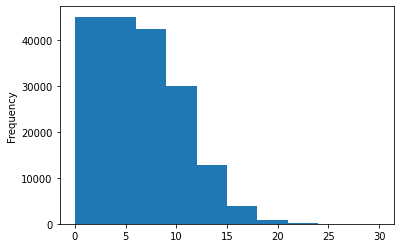

In [99]:
train_df.line_number.plot.hist()

# We can notice that most of the line numbers lie in the 0~20 lines value.

In [100]:
# A scalar defining the depth of the one hot dimension.
line_number_depth = 20

# Use tensorflow to create one-hot-encoded tensors for the line_number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=20)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=20)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=20)


Setting the depth parameter of tf.one_hot to 15 means any sample with a "line_number" value of over 15 gets set to a tensor of all 0's, where as any sample with a "line_number" of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the "line_number" value.

> 🔑 Note: We could create a one-hot tensor which has room for all of the __potential values__ of "line_number" (depth=30), however, this would end up in a tensor of __double__ the size of our current one (depth=15) where the vast majority of values are 0 (sparse). Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we __would not be gaining much information about our data for doubling our feature space__. This kind of problem is called the _curse of dimensionality_. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

In [101]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [102]:
# Do the same thing, with the total lines
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<AxesSubplot:ylabel='Frequency'>

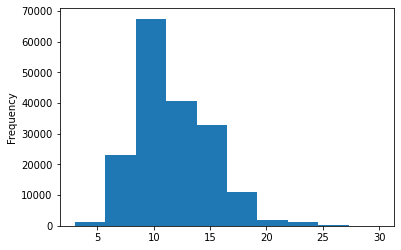

In [103]:
train_df['total_lines'].plot.hist()

In [104]:
np.percentile(train_df.total_lines, 98)

20.0

In [105]:
total_lines_depth = 20

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### 🚂 Build a input pipeline using the tf.data API

In [106]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot,
                                                                  train_sentences,
                                                                  train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# 🏋️‍♀️ Model Training

In [107]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = universal_sentence_encoder(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# 2. Char-level embeddings
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_tokens = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_tokens)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(line_number_depth,), dtype=tf.int32, name='line_number_inputs')
# (1, ) means the length of one array is 15, and there can be as many lists as possible

x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                  outputs=x)

# 4. Total lines input
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                 outputs=y)

# 5. Combine the token and char embedding layers into hybrid
combined_embeddings = layers.Concatenate(name='hybrid_embedding')([token_model.output, char_model.output])

z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with the hybrid embedding
z = layers.Concatenate(name='hybrid_embedding_with_positional_embedding')([line_number_model.output,
                                                                           total_lines_model.output,
                                                                           z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax')(z)

# 8. Put the model together
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                                outputs=output_layer)

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

In [108]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [109]:
model_5_history = model_5.fit(train_pos_char_token_dataset,
                             steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                             epochs=3,
                             validation_data=val_pos_char_token_dataset,
                             validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 102s 173ms/step - loss: 1.0939 - accuracy: 0.7264 - val_loss: 0.9772 - val_accuracy: 0.8115
Epoch 2/3
562/562 [==============================] - 105s 187ms/step - loss: 0.9637 - accuracy: 0.8174 - val_loss: 0.9479 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 138s 246ms/step - loss: 0.9454 - accuracy: 0.8278 - val_loss: 0.9370 - val_accuracy: 0.8351


# ✍🏽 Model Evaluation


In [110]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 34s 36ms/step - loss: 0.9339 - accuracy: 0.8348


[0.9339170455932617, 0.8348338603973389]

In [111]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

array([[0.48283643, 0.11300842, 0.01364156, 0.3734241 , 0.01708954],
       [0.5287185 , 0.09684604, 0.04386057, 0.31951505, 0.01105994],
       [0.26551786, 0.12391909, 0.10964373, 0.43731368, 0.06360567],
       ...,
       [0.03657788, 0.12549873, 0.03669219, 0.02967492, 0.77155626],
       [0.03268503, 0.306673  , 0.07613857, 0.02811945, 0.55638397],
       [0.2535387 , 0.5518059 , 0.08979826, 0.04996707, 0.05489003]],
      dtype=float32)

In [112]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [113]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_5_preds)

In [114]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embedding": model_1_results,
    "pretrained token embedding layer": model_2_results,
    "Conv1D with character-level embedding":model_3_results,
    "Token & Char Hybrid Embedding w/ Bi-LSTM": model_4_results,
    "Token & Char & Positional Embedding w/ Bi-LSTM": model_5_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,66.483516,0.668206,0.664835,0.618607
custom_token_embedding,78.531709,0.781942,0.785317,0.782847
pretrained token embedding layer,71.445121,0.714712,0.714451,0.711513
Conv1D with character-level embedding,65.503773,0.650150,0.655038,0.645507
Token & Char Hybrid Embedding w/ Bi-LSTM,74.076526,0.739666,0.740765,0.738224
Token & Char & Positional Embedding w/ Bi-LSTM,83.483384,0.833833,0.834834,0.833971


![title](img/conclusion.png) 

### The tribrid model performs the best by a fair margin

Although under performing compared to the model shown in the paper, the model is only trained on 10% of the data.

We can upscale this model to get better scores.


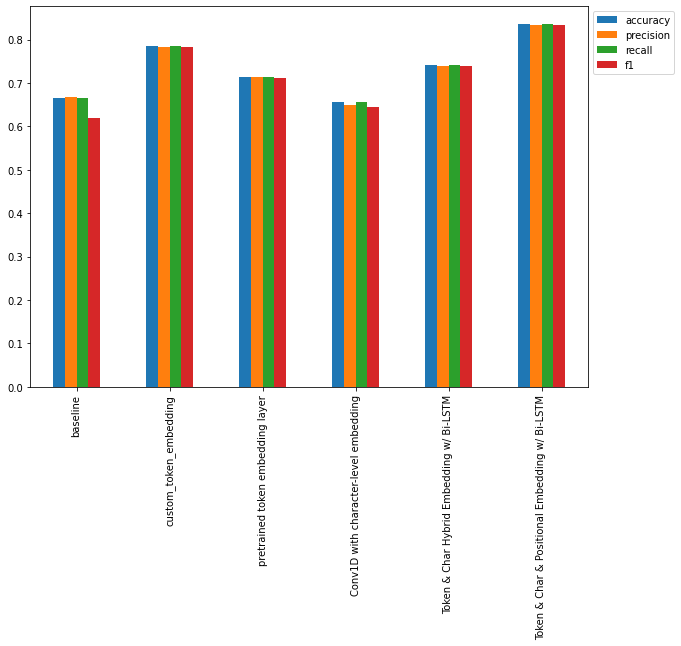

In [115]:
# Reduce the accuracy to the same scale as others
all_model_results['accuracy'] = all_model_results['accuracy']/100

# Plot and compare the model results on a bar chart
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

<AxesSubplot:>

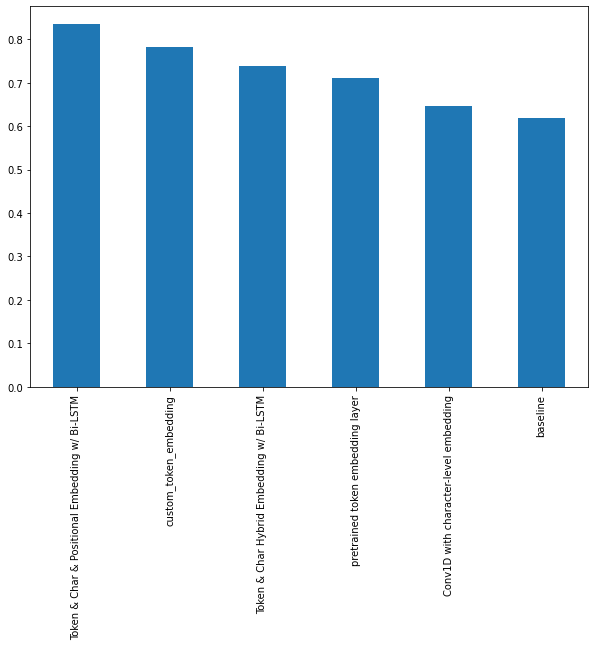

In [116]:
# Plot the f1 results alone
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10,7))

In [117]:
model_5.save('model_5/saved_model')

INFO:tensorflow:Assets written to: model_5/saved_model/assets


INFO:tensorflow:Assets written to: model_5/saved_model/assets


# ✍🏽 Model 5 Evaluation on the Test dataset

In [118]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                             test_total_lines_one_hot,
                                                             test_sentences,
                                                             test_chars))

test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))

test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [119]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                 verbose=1)

test_preds = tf.argmax(test_pred_probs, axis=1) # returns index in that sample's probability array
test_preds[:10]

942/942 [==============================] - 25s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [120]:
test_results = calculate_results(y_true=test_labels_encoded,
                                y_pred=test_preds)
test_results

{'accuracy': 82.9732868757259,
 'precision': 0.8284115378063048,
 'recall': 0.829732868757259,
 'f1': 0.828775254489663}

The model has yet to match the performance of the results in the paper (f1 score of 90, while ours is only 82).

### Model Improvements that can be made
* Train on full dataset
* Fine-tune pretrained embeddings


## Find the most wrong predictions
One of the best ways to investigate where your model is performing badly, is to visualize the "most wrong" predictions, meaning ground truth != prediction. 

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong. (it's confident it has the right answer, but is actually wrong).

Doing so, will provide us with valuable information on how to further improve the model or fix the labels in the data.

The code below will allow us to visualize the most wrong predictions from the test dataset.

In [123]:
# Convert all our integer based test predictions into their string-based class names
# Get a list of the class names of the test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',


__Add new columns to our test DataFrame, like the following:__
* A 'prediction' (string) column containing our tribrid model's prediction for a given sample
* A 'pred_prob' (float) column containing our tribrid model's confidence for that given prediction
* A 'correct' (bool) column to indicate whether or not the tribrid model's prediction matches the ground truth

In [124]:
# Create a prediction-enriched dataframe
test_df['prediction'] = test_pred_classes # Creates a column with test prediction class names

# Unlike argmax which returns the index, reduce_max returns the maximum prediction probability
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy()

# Create a binary column for whether the prediction matches the ground truth or not
test_df['correct?'] = test_df['prediction'] == test_df['target']

test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct?
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.458921,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.328757,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.766513,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.656556,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.752266,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.899854,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.545928,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.472478,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.474701,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.567185,True


__Sort the dataframe to show the samples where the pred_prob is highest and prediction was wrong (correct? = False)__

In [134]:
top_100_wrong = test_df[test_df['correct?'] == False].sort_values('pred_prob', ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct?
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.953462,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.943132,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.928377,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.925926,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.924290,False
...,...,...,...,...,...,...,...
12456,RESULTS,icd patients were randomized @:@ to automatic ...,1,13,METHODS,0.836775,False
7968,BACKGROUND,dpbrn hygienists internet quality improvement ...,12,12,CONCLUSIONS,0.836494,False
18206,OBJECTIVE,in a randomized controlled trial we examined t...,2,12,METHODS,0.835789,False
546,RESULTS,"primarily , we assessed the difference between...",3,13,METHODS,0.835692,False


In [135]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9534620642662048, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9431322813034058, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9283771514892578, Line number: 4, Total lines: 13

Text:
baseline measures included sociodemographics , standardized anthropometrics , asthma control test ( act ) , gerd symptom assessment scale , pittsburgh sleep quality index , and berlin questionnaire for sleep apnea .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9259259700775146, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9242895841598511, Line number: 0, Total lines: 11

Text:
to asses

One thing that can be noticed about the wrong predictions is that the many of the samples are labelled incorrectly/labels are ambiguous (e.g a line in a abstract could potentially be labelled OBJECTIVE or BACKGROUND and still make sense).

## Active Learning
The next step would be to go through the training and test dataset, update the labels and retrain a model. The process of using a model to help improve/investigate your dataset's labels is often referred to as active learning

Train the model on the 200k dataset

In [140]:
!ls data/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt   test.txt  train.txt train.zip


In [150]:
data_dir_200k = "data/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [151]:
# Read the lines of the training dataset, into a variable
train_lines = get_lines(data_dir_200k + "train.txt") 

# Show the first 10 lines
train_lines[:10] 

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [153]:
%%time

# Get the data and preprocess it
train_samples_200k = preprocess_text(data_dir_200k + 'train.txt')
val_samples_200k = preprocess_text(data_dir_200k + 'dev.txt') # dev is another name for validation
test_samples_200k = preprocess_text(data_dir_200k + 'test.txt')
print("No. of training samples: {} \nNo. of validation samples: {} \nNo. of testing samples: {}"
        .format(len(train_samples_200k), len(val_samples_200k), len(test_samples_200k))
)

No. of training samples: 2211861 
No. of validation samples: 28932 
No. of testing samples: 29493
CPU times: user 3.71 s, sys: 505 ms, total: 4.22 s
Wall time: 4.26 s


In [160]:
import pandas as pd

# Turn dictionaries into pandas DataFrame to better visualize it
train_df_200k = pd.DataFrame(train_samples_200k)
val_df_200k = pd.DataFrame(val_samples_200k)
test_df_200k = pd.DataFrame(test_samples_200k)

# Show first 13 lines of data
train_df.head(11)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


## Make the 200k train token dataset

In [161]:
train_sentences_200k = train_df_200k['text'].tolist()
val_sentences_200k = val_df_200k['text'].tolist()
test_sentences_200k = test_df_200k['text'].tolist()

len(train_sentences_200k), len(val_sentences_200k), len(test_sentences_200k),

(2211861, 28932, 29493)

In [163]:
train_sentences_200k[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

Feature Engineering to get one-hot encoded labels

In [166]:
train_labels_one_hot_200k = one_hot_encoder.fit_transform(train_df_200k['target'].to_numpy().reshape(-1,1))
val_labels_one_hot_200k = one_hot_encoder.fit_transform(val_df_200k['target'].to_numpy().reshape(-1,1))
test_labels_one_hot_200k = one_hot_encoder.fit_transform(test_df_200k['target'].to_numpy().reshape(-1,1))

In [167]:
tf.constant(train_labels_one_hot_200k)

<tf.Tensor: shape=(2211861, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])>

In [178]:
train_chars_200k = [split_chars(sentence) for sentence in train_sentences_200k]
val_chars_200k = [split_chars(sentence) for sentence in val_sentences_200k]
test_chars_200k = [split_chars(sentence) for sentence in test_sentences_200k]

<AxesSubplot:ylabel='Frequency'>

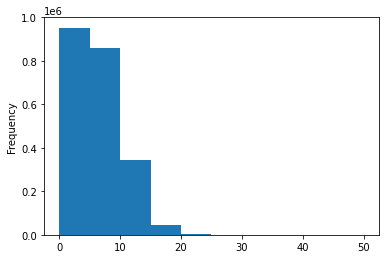

In [172]:
train_df_200k.line_number.plot.hist()

In [173]:
# Since we can notice most of the line numbers lie in the 0 - 20 line value, we set the depth to be 20

line_number_depth=20

# Use tensorflow to create one-hot-encoded tensors for the line_number column
train_line_numbers_one_hot_200k = tf.one_hot(train_df_200k['line_number'].to_numpy(), depth=line_number_depth)
val_line_numbers_one_hot_200k = tf.one_hot(val_df_200k['line_number'].to_numpy(), depth=line_number_depth)
test_line_numbers_one_hot_200k = tf.one_hot(test_df_200k['line_number'].to_numpy(), depth=line_number_depth)

In [174]:
train_line_numbers_one_hot_200k.shape, train_line_numbers_one_hot_200k[:20]

(TensorShape([2211861, 20]),
 <tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

In [175]:
# Do the same thing with total lines feature
np.percentile(train_df_200k.total_lines, 98)

20.0

<AxesSubplot:ylabel='Frequency'>

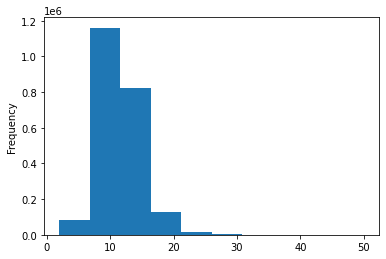

In [176]:
train_df_200k['total_lines'].plot.hist()

In [177]:
total_lines_depth = 20

train_total_lines_one_hot_200k = tf.one_hot(train_df_200k['total_lines'].to_numpy(), depth=total_lines_depth)
val_total_lines_one_hot_200k = tf.one_hot(val_df_200k['total_lines'].to_numpy(), depth=total_lines_depth)
test_total_lines_one_hot_200k = tf.one_hot(test_df_200k['total_lines'].to_numpy(), depth=total_lines_depth)

train_total_lines_one_hot_200k.shape, train_total_lines_one_hot_200k[:10]

(TensorShape([2211861, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

### 🚂 Build a input pipeline using the tf.data API

In [179]:
tribrid_model_train_data_200k = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot_200k,
                                                                  train_total_lines_one_hot_200k,
                                                                  train_sentences_200k,
                                                                  train_chars_200k))

tribrid_model_train_labels_200k = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_200k)
tribrid_model_train_dataset_200k = tf.data.Dataset.zip((tribrid_model_train_data_200k, tribrid_model_train_labels_200k))
tribrid_model_train_dataset_200k = tribrid_model_train_dataset_200k.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
tribrid_model_val_data_200k = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot_200k,
                                                              val_total_lines_one_hot_200k,
                                                              val_sentences_200k,
                                                              val_chars_200k))
tribrid_model_val_labels_200k = tf.data.Dataset.from_tensor_slices(val_labels_one_hot_200k)
tribrid_model_val_dataset_200k = tf.data.Dataset.zip((tribrid_model_val_data_200k, tribrid_model_val_labels_200k))
tribrid_model_val_dataset_200k = tribrid_model_val_dataset_200k.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [180]:
tribrid_model_train_dataset_200k, tribrid_model_val_dataset_200k

(<PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 20), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [181]:
model_5_history = model_5.fit(tribrid_model_train_dataset_200k,
                             steps_per_epoch=int(0.1 * len(tribrid_model_train_dataset_200k)),
                             epochs=3,
                             validation_data=tribrid_model_val_dataset_200k,
                             validation_steps=int(0.1 * len(tribrid_model_val_dataset_200k)))

Epoch 1/3
6912/6912 [==============================] - 1785s 258ms/step - loss: 0.9173 - accuracy: 0.8462 - val_loss: 0.9062 - val_accuracy: 0.8517
Epoch 2/3
6912/6912 [==============================] - 1880s 272ms/step - loss: 0.9043 - accuracy: 0.8549 - val_loss: 0.8956 - val_accuracy: 0.8632
Epoch 3/3
6912/6912 [==============================] - 1529s 221ms/step - loss: 0.8995 - accuracy: 0.8584 - val_loss: 0.8885 - val_accuracy: 0.8628


In [182]:
model_5.save('model_5/tribrid_200k_saved_model')

INFO:tensorflow:Assets written to: model_5/tribrid_200k_saved_model/assets


INFO:tensorflow:Assets written to: model_5/tribrid_200k_saved_model/assets


In [185]:
# Download and open example abstracts (copy and pasted from PubMed)
import json

with open("data/skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [186]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [188]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [190]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [199]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=20) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [193]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [195]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [200]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.44440904, 0.0895683 , 0.02664932, 0.3944996 , 0.04487377],
       [0.12836225, 0.04965863, 0.65367866, 0.0987638 , 0.06953672],
       [0.14011009, 0.06320566, 0.63707995, 0.10588949, 0.0537148 ],
       [0.11617265, 0.14510854, 0.504328  , 0.08285461, 0.1515362 ],
       [0.05102038, 0.0866999 , 0.38781208, 0.04537955, 0.42908806],
       [0.05262087, 0.05790544, 0.64530575, 0.0463637 , 0.19780424],
       [0.02565636, 0.11159401, 0.0903073 , 0.02222847, 0.75021386],
       [0.02028968, 0.10956138, 0.09573721, 0.02413413, 0.75027764]],
      dtype=float32)

In [201]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 2, 4, 4])>

Now we've got the predicted sequence label for each line in our sample abstract, let's write some code to visualize each sentence with its predicted label.



In [202]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [203]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


Nice! Isn't that much easier to read? I mean, it looks like our model's predictions could be improved, but how cool is that?

# 💡 Ideas

* Implement the model on the backend of the PubMed website to format any unstructured RCT abstract on the site
* Chrome browser extension that reads the HTML data of a RCT url and add structure to the abstract using the trained model
    * Allow users to correct any incorrect labels. Perhaps a "Is this label accurate?" popup when hovering over the abstract.
* Functionizing the abstract preprocessing pipeline instead of having to manually convert the data to a df, splicing, one hot encoding, finding the depth, etc etc.
* Merge the line_number and total_lines feature into one feature.
* Replace the TFHUB Sentence Encoder with TFHub BERT PubMed expert (a language model pretrained on pubmed texts) pretrained embedding.
* Train the model_5 for many epochs and use modelcheckpoints and earlystopping callbacks.